## **Abstract:**

Our study focused on comparing the race of victims against each other, narrowing it down to analyze potential changes over the time period leading up to COVID-19 and the years after to investigate a potential link between the pandemic, and increase in hate crimes to see whether or not there’s a causal link between the pandemic and changes in crime rate, frequency and targets. To explore this, we used crime data compiled through different sources, like the FBI, containing murders throughout the United States from 1976 to 2023. For this analysis question, the year range was narrowed down to start from 2016. It contained data about what state and city the crime took place, what the data source is, when it happened, the nature of the homicide, including the situation, weapon & victim count, victim’s age, race, sex & ethnicity, as well as the offender’s age, sex & race.

Using this data set, a decision tree was created using factors of year, offender age, month, state, offender race, and situation to predict the victim’s race for murder and non-negligent manslaughter to train a model and predict the victim’s race. Several comparisons were made, comparing white v. black victim, Asian v. white, Asian v. black, and Asian v. Native American or Alaskan Native. The decision tree made the most incorrect predictions when compared to white victims, no matter which combination, likely because the large proportion of victims is white among all data observations.

Another model was created comparing COVID-19 cases with the crime data set, starting from 2020-2023, filtering for crimes against Asian individuals. The results only had data in California, Arizona, Alaska, Alabama, and Arkansas. There does not appear to be a trend when comparing the graphs of COVID-19 cases across the 4 years v. crimes against Asian individuals over the 4 years among these 5 states, meaning there is likely neither a correlation nor causation that can be concluded between COVID-19 and the frequency of Asian hate crimes.

## **Introduction:**

**Prediction Quesiton**: Were Asian Americans more likely to be attacked in cities/towns with a higher amount of Covid cases due to rise in xenophobia during the Pandemic?

**Importance for client**: This research question can guide law enforcement in the future. Even though there may not be the same case of anti-asian hate, there will most likely be more xenophobia in the future. By analyzing this data, we can see if there was actually a rise during the pandemic of attacks on asian americans, and then law enforcement can protect groups in a similar scenario in the future.

## **Setting Up Data for Model Training:** (skip to the end to see MAIN DISCUSSION)

In [404]:
# Setting up environment:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [405]:
# loading in dataset as dataframe:
# WARNING: we cleaned the dataset in prior iterations of the project.
# We included specific years of 2016 - 2023 and only "Murder and non-negligent manslaughter"
df = pd.read_csv("cleaned_df.csv")
print(df.shape)

# previewing the data:
# df.head(5)
df.columns

(13794, 21)


Index(['Unnamed: 0', 'State', 'Agency', 'Source', 'Solved', 'Year', 'Month',
       'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'VicCount', 'OffCount'],
      dtype='object')

In [406]:
# selecting relevant columns to use for model analysis:
df_new = df[['Year', 'Month', 'State', 'OffRace', 'OffAge', 'Situation', 'VicRace']]
# df_new.head(5)

In [407]:
# checking for NaNs:
print(df_new.isna().sum())

# dropping missing values for 'OffRace' since can not impute for categorical:
# df_new = df_new.dropna(subset=['OffRace'], axis=0)
df_new['OffRace'] = df_new["OffRace"].fillna('Unknown')


# imputing missing values for 'OffAge' with median:
df_new['OffAge'] = df_new['OffAge'].fillna(df_new['OffAge'].median())

# imputing missing values for 'VicRace' with 'Unknown':
df_new['VicRace'] = df_new['VicRace'].fillna('Unknown')

# previewing new/cleaned dataframe:
print(df_new.head())
print(df_new.isna().sum())

Year            0
Month           0
State           0
OffRace      4413
OffAge       4441
Situation       0
VicRace       210
dtype: int64
   Year    Month   State                            OffRace  OffAge  \
0  2016  January  Alaska  American Indian or Alaskan Native    21.0   
1  2016  January  Alaska                              White    15.0   
2  2016  January  Alaska                              White    15.0   
3  2016  January  Alaska                              White    34.0   
4  2016  January  Alaska  American Indian or Alaskan Native    33.0   

                          Situation                            VicRace  
0     Single victim/single offender  American Indian or Alaskan Native  
1  Multiple victims/single offender                              White  
2  Multiple victims/single offender                              White  
3  Single victim/multiple offenders  American Indian or Alaskan Native  
4     Single victim/single offender  American Indian or Alaskan Nativ

/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['OffRace'] = df_new["OffRace"].fillna('Unknown')
/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['OffAge'] = df_new['OffAge'].fillna(df_new['OffAge'].median())
/var/folders/_2/3z4yyh_x2pvfz5gh_k92c24h0000gn/T/ipykernel_30698/3505088697.py:13: SettingWithCopyWarning: 
A value is trying to 

**One Hot Encoding Data for Model:**

In [408]:
# separating numerical and categorical columns:

# numerical columns:
num_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)

# categorical columns:
cat_cols = df_new.select_dtypes(exclude=[np.number]).columns.tolist()
# cat_cols.remove('VicRace')
print(cat_cols)

['Year', 'OffAge']
['Month', 'State', 'OffRace', 'Situation', 'VicRace']


In [409]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#splitting the data to before and after 2020
df_pre_covid = df_new[df_new['Year']<2020]
df_post_covid = df_new[df_new['Year']>=2020]

y_pre = df_pre_covid['VicRace']
y_post = df_post_covid['VicRace']

X_raw_pre = df_pre_covid.drop(columns=['VicRace'])
X_raw_post = df_post_covid.drop(columns=['VicRace'])

# one hot encoding categorical features:
X_pre = pd.get_dummies(X_raw_pre, drop_first=True)
X_post = pd.get_dummies(X_raw_post, drop_first = True)

# splitting data into test/train:
X_train_pre, X_test_pre, Y_train_pre, Y_test_pre = train_test_split(X_pre, y_pre, test_size=0.2, random_state=42)
X_train_post, X_test_post, Y_train_post, Y_test_post = train_test_split(X_post, y_post, test_size=0.2, random_state=42)

## **Training the PRE-Covid Model:**

Best min_sample_leaf value: 1 with Accuracy of 0.349


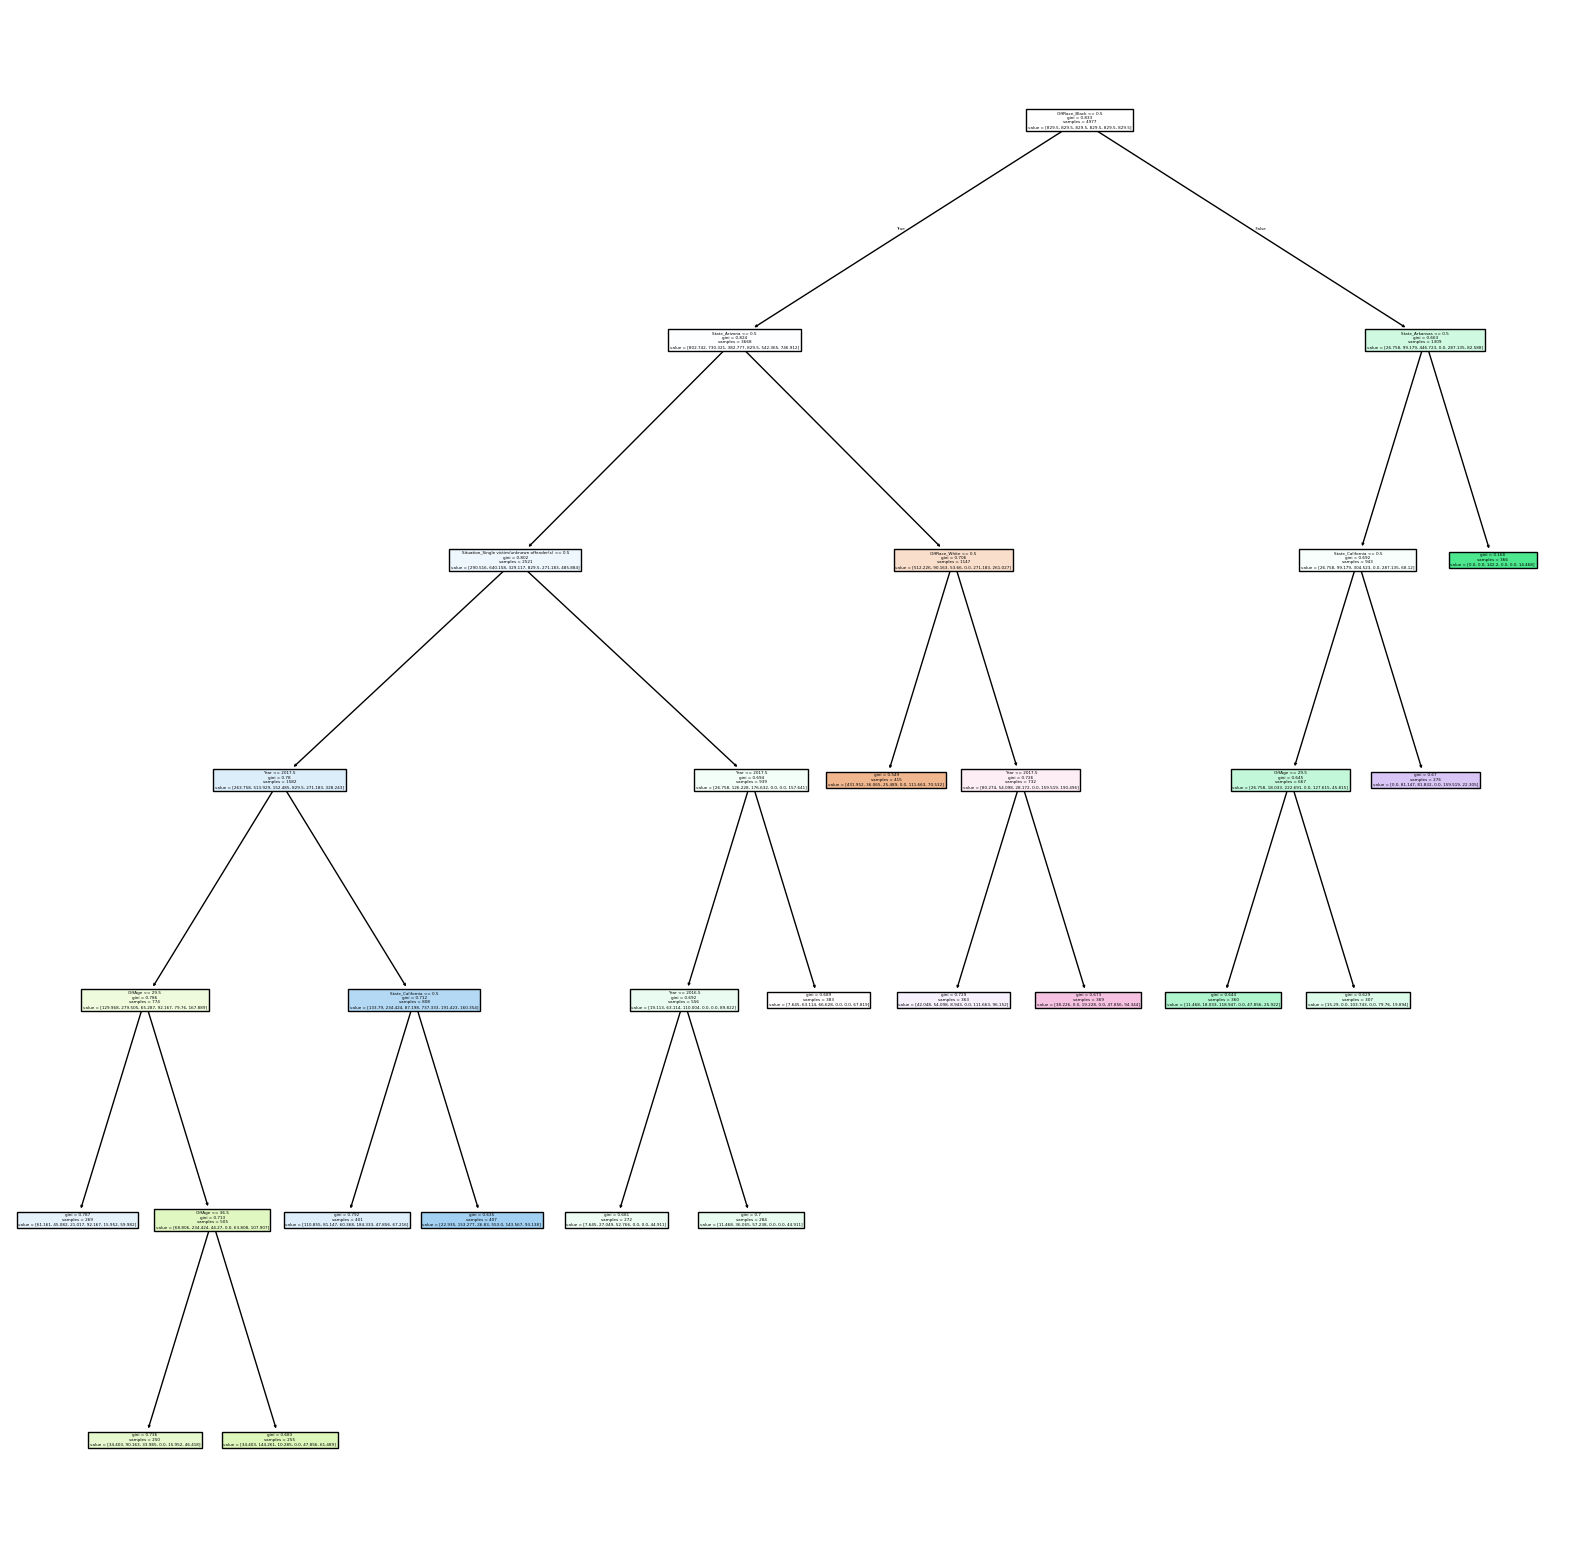

In [432]:
# importing all necessary libraries:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# weights = {
#     'White': (Y_test_pre == 'White').mean(),
#     'Black': (Y_test_pre == 'Black').mean(),
#     'Asian': (Y_test_pre == 'Asian').mean(),
#     'American Indian or Alaskan Native': (Y_test_pre == 'American Indian or Alaskan Native').mean(),
#     'Native Hawaiian or Pacific Islander': (Y_test_pre == 'Native Hawaiian or Pacific Islander').mean()
# }

model = DecisionTreeClassifier(min_samples_leaf=250, random_state=42, class_weight='balanced')
model.fit(X_train_pre, Y_train_pre)
y_hat = model.predict(X_test_pre)


df_test_pre = df_pre_covid.loc[X_test_pre.index].copy()
df_test_pre['Predicted'] = y_hat
df_test_pre = df_test_pre.reset_index(drop=True)


acc_list = []
leaf_values = list(range(1, 26))

for leaf in leaf_values:
    model = DecisionTreeClassifier(min_samples_leaf=250, random_state=42, class_weight='balanced')
    model.fit(X_train_pre, Y_train_pre)
    y_hat = model.predict(X_test_pre)
    acc = accuracy_score(Y_test_pre, y_hat)
    acc_list.append(acc)

best_leaf = leaf_values[acc_list.index(max(acc_list))]
best_acc = max(acc_list)

print(f'Best min_sample_leaf value: {best_leaf} with Accuracy of {best_acc:.3f}')

plt.figure(figsize=(20, 20))
plot_tree(model, filled=True, feature_names=model.feature_names_in_)
plt.show()

In [433]:
print(df_test_pre['Predicted'].unique())

['Black' 'White' 'Unknown' 'Native Hawaiian or Pacific Islander' 'Asian'
 'American Indian or Alaskan Native']


In [434]:
for i in range(10):
    print(f"Predicted: {y_hat[i]} | Actual: {Y_test_pre.iloc[i]}")

Predicted: Black | Actual: Black
Predicted: White | Actual: White
Predicted: Unknown | Actual: White
Predicted: Native Hawaiian or Pacific Islander | Actual: Black
Predicted: Asian | Actual: Unknown
Predicted: Unknown | Actual: White
Predicted: Unknown | Actual: White
Predicted: Black | Actual: White
Predicted: Native Hawaiian or Pacific Islander | Actual: Black
Predicted: Black | Actual: White


In [435]:
count_blackpred_whiteactual = 0
for i in range(min(len(y_hat), len(Y_test_pre))):
    if y_hat[i] == 'Black' and Y_test_pre.iloc[i] == 'White':
        count_blackpred_whiteactual += 1

print("predicted Black, but was White in actual:", count_blackpred_whiteactual / min(len(y_hat), len(Y_test_pre)))


count_whitepred_blackactual = 0
for i in range(min(len(y_hat), len(Y_test_pre))):
    if y_hat[i] == 'White' and Y_test_pre.iloc[i] == 'Black':
        count_whitepred_blackactual += 1

print("predicted White, but was Black in actual:", count_whitepred_blackactual / min(len(y_hat), len(Y_test_pre)))

predicted Black, but was White in actual: 0.10522088353413654
predicted White, but was Black in actual: 0.04096385542168675


It appears 7% of the data's `VicRace` was predicted as 'Black' when the actual value was 'White'. 11.6% of the data's 'VicRace' was predicted as 'White' when the actual value was 'Black'. I'm not sure if there's some sort of bias here due to a large portion of the data having White victims, but it appears the model has a discrepancy in predicting these values. I will now see if prediction in Asian races with White (majority of data) has the same pattern. This isn't also conclusive due to not seeing all the other statistics (like crosstabs).

In [436]:
count_white_predicted_but_actual_asian = 0
count_asian_predicted_but_actual_white = 0
total_relevant = 0

for i in range(min(len(y_hat), len(Y_test_pre))):
    true_label = Y_test_pre.iloc[i]
    pred_label = y_hat[i]

    if true_label in ['White', 'Asian']:
        total_relevant += 1  # Only count samples that are actually White or Asian

        if true_label == 'Asian' and pred_label == 'White':
            count_white_predicted_but_actual_asian += 1

        elif true_label == 'White' and pred_label == 'Asian':
            count_asian_predicted_but_actual_white += 1

print("Predicted White but was actually Asian (as % of White+Asian):", count_white_predicted_but_actual_asian / total_relevant)
print("Predicted Asian but was actually White (as % of White+Asian):", count_asian_predicted_but_actual_white / total_relevant)


Predicted White but was actually Asian (as % of White+Asian): 0.00423728813559322
Predicted Asian but was actually White (as % of White+Asian): 0.1440677966101695


In [437]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'White'])) & (predictions.isin(['Asian', 'White']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)

Predicted     Asian     White
Actual                       
Asian      0.500000  0.500000
White      0.443478  0.556522


In [438]:
white_count = (Y_test_pre == 'White').sum()
total_count = len(Y_test_pre)
white_ratio = white_count / total_count

print("Ratio of White victims over all victims:", white_ratio)

Ratio of White victims over all victims: 0.5461847389558233


We have that similar comparison here. Except, it's clear that there were more predictions for 'White' compared to that of 'Asians'. This might be due to there being a majority 'White' `VicRace` in he observations of the data (seen in code above). Let's try this with the other races crosstabbed with Asians to confirm these suspicions.

In [439]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


black_count = (Y_test_pre == 'Black').sum()
total_count = len(Y_test_pre)
black_ratio = black_count / total_count

print("\nRatio of Black victims over all victims:", black_ratio)

Predicted     Asian     Black
Actual                       
Asian      0.375000  0.625000
Black      0.083612  0.916388

Ratio of Black victims over all victims: 0.3718875502008032


In [440]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'American Indian or Alaskan Native'])) & (predictions.isin(['Asian', 'American Indian or Alaskan Native']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


native_count = (Y_test_pre == 'American Indian or Alaskan Native').sum()
total_count = len(Y_test_pre)
native_ratio = native_count / total_count

print("\nRatio of American Indian or Alaskan Native victims over all victims:", native_ratio)

Predicted                          American Indian or Alaskan Native     Asian
Actual                                                                        
American Indian or Alaskan Native                           0.764706  0.235294
Asian                                                       0.250000  0.750000

Ratio of American Indian or Alaskan Native victims over all victims: 0.04578313253012048


In [441]:
asian_count = (Y_test_pre == 'Asian').sum()
total_count = len(Y_test_pre)
asian_ratio = asian_count / total_count

print("\nRatio of Asian victims over all victims:", asian_ratio)


Ratio of Asian victims over all victims: 0.02248995983935743


What's interesting is we see a similar pattern for 'Black' populations in the data, corresponding to the pattern seen in the 'White''s crosstab. Then, we get to the Native Americans cross tab with 'Asian', where we see they're very disjoint in predictive to actual values. I looked at the total of each population out of all victims, and it seems the 'White' has the largest population, followed by 'Black', then by Native Americans, and finally 'Asian'. 

I believe there's a discrepancy in our model, or a large bias due to the lack of data on against-Asian crimes that needs to be addressed in the future. We'll most likely need to find a crime dataset that focuses on Asian populations. This highlights the importance of having inclusive datasets and not focusing on the majority populations. This also might mean that we need to report more crimes against Asian populations, or that most Asians aren't victims in crimes. More explanation is needed for this topic.

## **Training the POST-Covid Model:**

Best min_sample_leaf value: 1 with Accuracy of 0.409


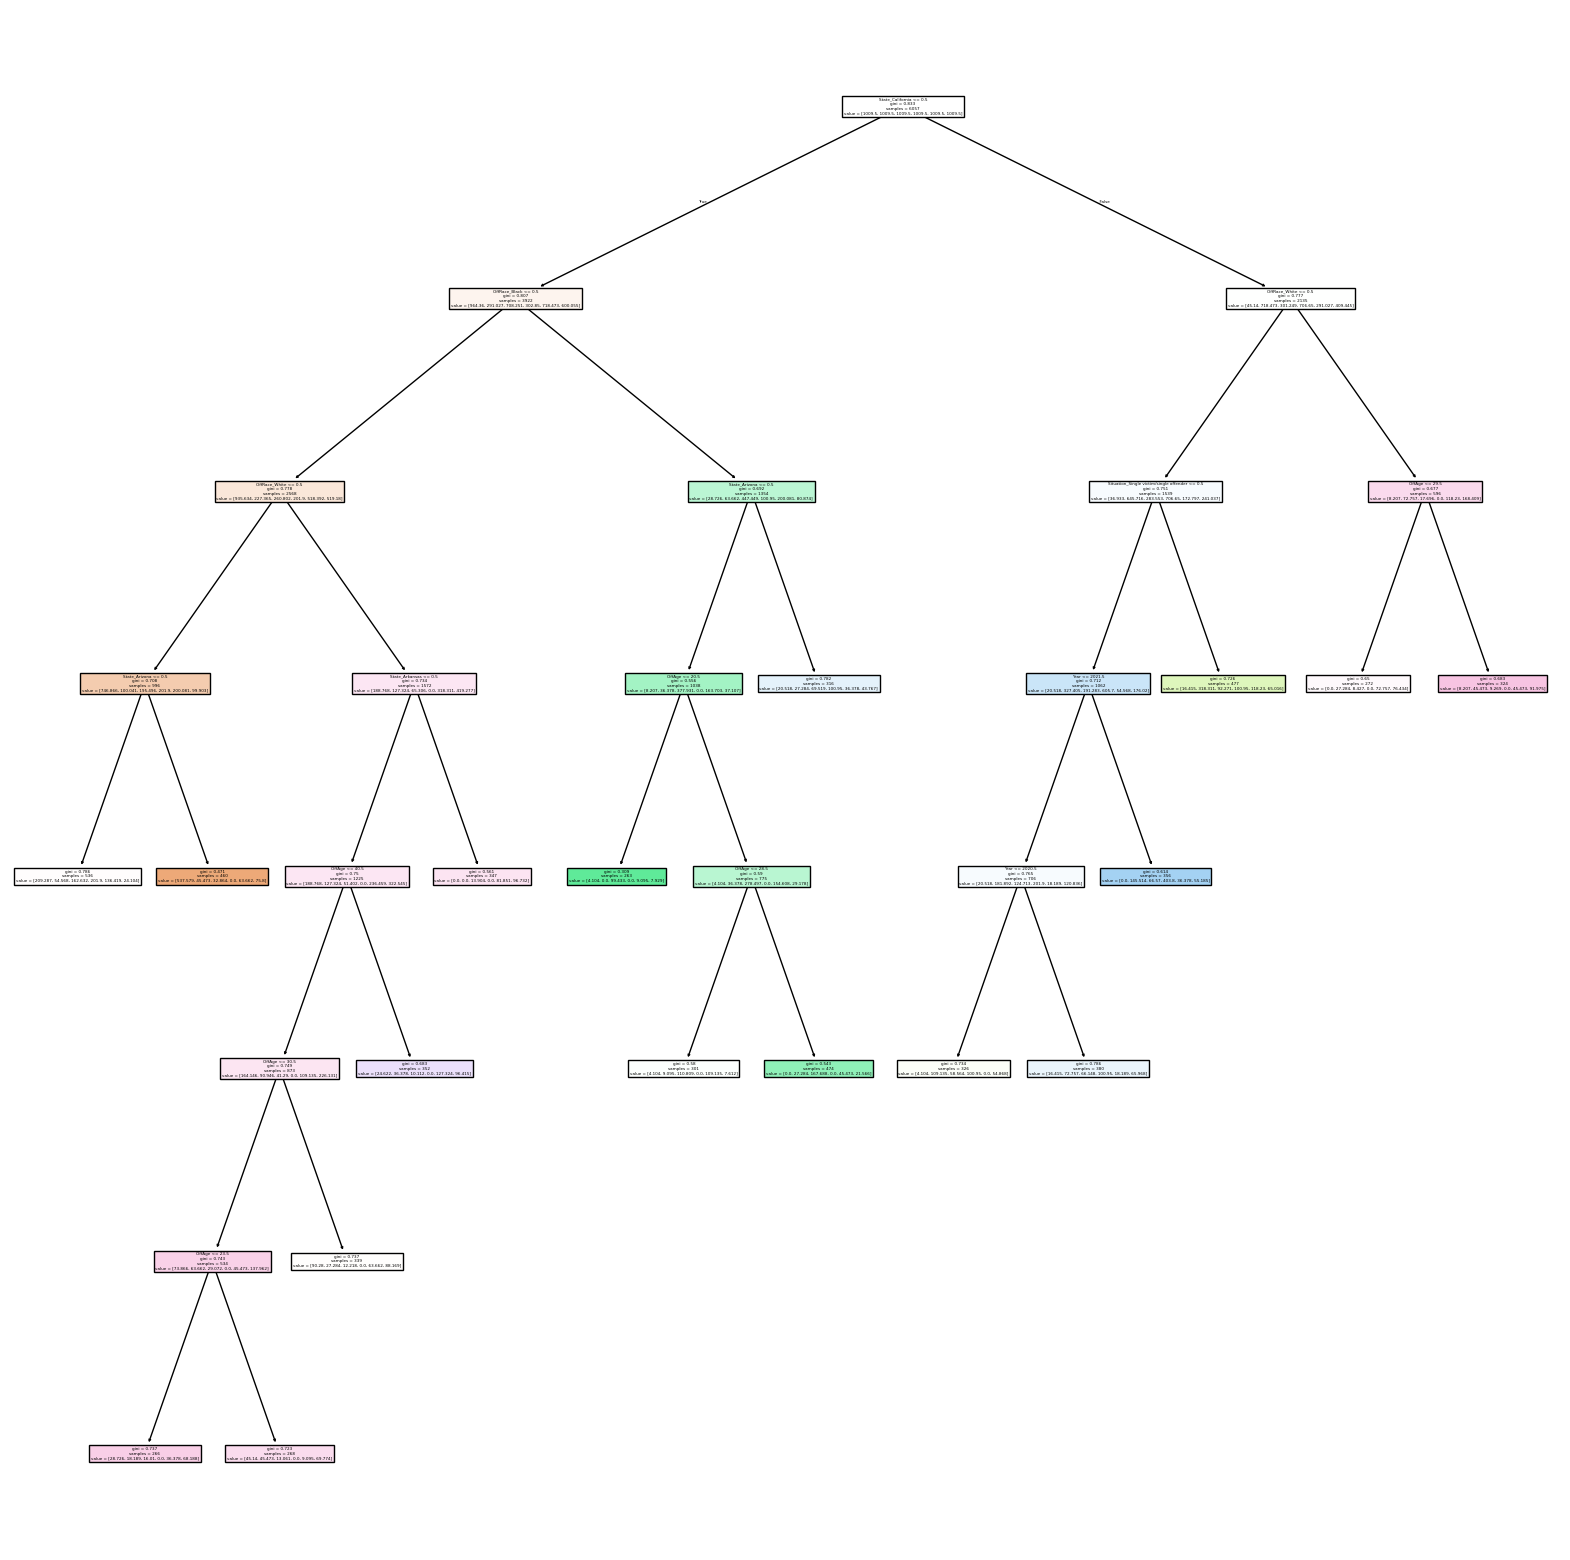

In [455]:
# importing all necessary libraries:
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# weights = {
#     'White': (Y_test_post == 'White').mean(),
#     'Black': (Y_test_post == 'Black').mean(),
#     'Asian': (Y_test_post == 'Asian').mean(),
#     'American Indian or Alaskan Native': (Y_test_post == 'American Indian or Alaskan Native').mean(),
#     'Native Hawaiian or Pacific Islander': (Y_test_post == 'Native Hawaiian or Pacific Islander').mean()
# }

model_post = DecisionTreeClassifier(min_samples_leaf=250, random_state=42, class_weight='balanced')
model_post.fit(X_train_post, Y_train_post)
y_hat_post = model_post.predict(X_test_post)


df_test_post = df_post_covid.loc[X_test_post.index].copy()
df_test_post['Predicted'] = y_hat_post
df_test_post = df_test_post.reset_index(drop=True)


from sklearn.metrics import accuracy_score

acc_list_post = []
leaf_values = list(range(1, 26))

for leaf in leaf_values:
    model_post = DecisionTreeClassifier(min_samples_leaf=250, random_state=42, class_weight='balanced')
    model_post.fit(X_train_post, Y_train_post)
    y_hat_post = model_post.predict(X_test_post)
    acc_post = accuracy_score(Y_test_post, y_hat_post)
    acc_list_post.append(acc_post)

best_leaf_post = leaf_values[acc_list_post.index(max(acc_list_post))]
best_acc_post = max(acc_list_post)

print(f'Best min_sample_leaf value: {best_leaf_post} with Accuracy of {best_acc_post:.3f}')

plt.figure(figsize=(20, 20))
plot_tree(model_post, filled=True, feature_names=model_post.feature_names_in_)
plt.show()


In [456]:
for i in range(10):
    print(f"Predicted: {y_hat_post[i]} | Actual: {Y_test_post.iloc[i]}")

Predicted: Black | Actual: Black
Predicted: Native Hawaiian or Pacific Islander | Actual: White
Predicted: White | Actual: White
Predicted: American Indian or Alaskan Native | Actual: American Indian or Alaskan Native
Predicted: White | Actual: Black
Predicted: White | Actual: White
Predicted: White | Actual: Unknown
Predicted: American Indian or Alaskan Native | Actual: American Indian or Alaskan Native
Predicted: Native Hawaiian or Pacific Islander | Actual: Black
Predicted: White | Actual: White


In [457]:
count_blackpred_whiteactual = 0
for i in range(min(len(y_hat_post), len(Y_test_post))):
    if y_hat_post[i] == 'Black' and Y_test_post.iloc[i] == 'White':
        count_blackpred_whiteactual += 1

print("predicted Black, but was White in actual:", count_blackpred_whiteactual / min(len(y_hat_post), len(Y_test_post)))


count_whitepred_blackactual = 0
for i in range(min(len(y_hat_post), len(Y_test_post))):
    if y_hat_post[i] == 'White' and Y_test_post.iloc[i] == 'Black':
        count_whitepred_blackactual += 1

print("predicted White, but was Black in actual:", count_whitepred_blackactual / min(len(y_hat_post), len(Y_test_post)))

predicted Black, but was White in actual: 0.022442244224422443
predicted White, but was Black in actual: 0.023762376237623763


In [458]:
count_white_predicted_but_actual_asian = 0
count_asian_predicted_but_actual_white = 0
total_relevant = 0

for i in range(min(len(y_hat_post), len(Y_test_post))):
    true_label = Y_test_post.iloc[i]
    pred_label = y_hat_post[i]

    if true_label in ['White', 'Asian']:
        total_relevant += 1  # Only count samples that are actually White or Asian

        if true_label == 'Asian' and pred_label == 'White':
            count_white_predicted_but_actual_asian += 1

        elif true_label == 'White' and pred_label == 'Asian':
            count_asian_predicted_but_actual_white += 1

print("Predicted White but was actually Asian (as % of White+Asian):", count_white_predicted_but_actual_asian / total_relevant)
print("Predicted Asian but was actually White (as % of White+Asian):", count_asian_predicted_but_actual_white / total_relevant)


Predicted White but was actually Asian (as % of White+Asian): 0.005931198102016607
Predicted Asian but was actually White (as % of White+Asian): 0.11150652431791222


In [459]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'White'])) & (predictions.isin(['Asian', 'White']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)

Predicted     Asian     White
Actual                       
Asian      0.545455  0.454545
White      0.214612  0.785388


In [460]:
white_count = (y_hat_post == 'White').sum()
total_count = len(y_hat_post)
white_ratio = white_count / total_count

print("Ratio of White victims over all victims:", white_ratio)

Ratio of White victims over all victims: 0.2627062706270627


In [461]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


black_count = (Y_test_post == 'Black').sum()
total_count = len(Y_test_post)
black_ratio = black_count / total_count

print("\nRatio of Black victims over all victims:", black_ratio)

Predicted     Asian     Black
Actual                       
Asian      0.857143  0.142857
Black      0.261905  0.738095

Ratio of Black victims over all victims: 0.37755775577557754


In [462]:
predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'American Indian or Alaskan Native'])) & (predictions.isin(['Asian', 'American Indian or Alaskan Native']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print(ct)


native_count = (Y_test_post == 'American Indian or Alaskan Native').sum()
total_count = len(Y_test_post)
native_ratio = native_count / total_count

print("\nRatio of American Indian or Alaskan Native victims over all victims:", native_ratio)

Predicted                          American Indian or Alaskan Native     Asian
Actual                                                                        
American Indian or Alaskan Native                           0.942308  0.057692
Asian                                                       0.500000  0.500000

Ratio of American Indian or Alaskan Native victims over all victims: 0.042244224422442245


In [463]:
asian_count = (Y_test_post == 'Asian').sum()
total_count = len(Y_test_post)
asian_ratio = asian_count / total_count

print("\nRatio of Asian victims over all victims:", asian_ratio)


Ratio of Asian victims over all victims: 0.02178217821782178


## **MAIN DISCUSSION:**

### The Inspiration:
A major theme in this exploration has been how one deals with possible representation bias in the dataset. From the minimality of data observations where the victim was listed as Asian, to over 50% of the data observations' Victim races being listed as White, the analysts faced the challenge of how to deal with this issue. However, there was found a way to rely on this factor instead of turning away from the dataset, and realized one could inform future experiments and data collectors on the findings.

Without getting too much into technicality, the data analysts of this project trained 2 ML models on 'Murder and non-negligent manslaughter' data in the US to predict what the victim's race would be. The 2 models were different in that the first focused on data from 2016 to before 2020 (Covid's start) and the second focused on data from year 2020 to 2023 (post Covid start). 

One might ask why before and after Covid? Some of the analysts observed an increase, or climb, in hate crimes against Asians after Covid started. In fact, BBC's 2021 article on hate crimes rising against Asian Americans states, "Advocates and activists say these are hate crimes, and often linked to rhetoric that blames Asian people for the spread of Covid-19" ("Covid 'hate Crimes' against Asian Americans on Rise"). The analysts state this to show the significance the findings might have on the larger community.

### Findings:

1) 
Although not pretty, the tables below display the same statistics, just on data Pre-Covid and Post-Covid. On the left column, one has the actual values of Asian or Black that the victims represented across the respective rows. The top row represents the columns of whether the observation was predicted as Asian or Black. 

Pre-Covid, one can interpret that more observations that were actually victim race of Asian were predicted as Black than actual & predicted as Asian. The same applies to the Post-Covid table. This was interpreted to be due to there being significantly more Black victims being represented in the data, and that the specific ML model used was more prone to leaning predictions towards higher represented data. This would cause issue, but one can see that the Asian-Asian actual-predicted value of 0.375000 Pre-Covid increased to 0.857143 Post-Covid and that more Black represented data were being predicted as Asian Post-Covid. 

Because the model tends to predict groups that are more common in the data, the analysts believed that there was more Asian victims actually represented in the Post-Covid data in a significant manner. **What all this means is that there was more Asian victims represented in the Post-Covid data compared to Pre-Covid found through the model's possible bias.**

The same can be found within looking at Asian in comparison to other races like White.

In [464]:
predictions = pd.Series(y_hat)
truth = Y_test_pre.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print("PRE-COVID CROSS TAB: BLACK TO ASIAN IN VICTIM RACE:")
print(ct)


black_count = (Y_test_pre == 'Black').sum()
total_count = len(Y_test_pre)
black_ratio = black_count / total_count

print("\n")

# print("Ratio of Black victims over all victims (PRE COVID):", black_ratio, "\n")

predictions = pd.Series(y_hat_post)
truth = Y_test_post.reset_index(drop=True)

mask = (truth.isin(['Asian', 'Black'])) & (predictions.isin(['Asian', 'Black']))

predictions = predictions[mask]
truth = truth[mask]

ct = pd.crosstab(truth, predictions, rownames=['Actual'], colnames=['Predicted'], normalize='index')

print("POST-COVID CROSS TAB: BLACK TO ASIAN IN VICTIM RACE:")
print(ct)


black_count = (Y_test_post == 'Black').sum()
total_count = len(Y_test_post)
black_ratio = black_count / total_count

# print("Ratio of Black victims over all victims (POST COVID):", black_ratio)

PRE-COVID CROSS TAB: BLACK TO ASIAN IN VICTIM RACE:
Predicted     Asian     Black
Actual                       
Asian      0.375000  0.625000
Black      0.083612  0.916388


POST-COVID CROSS TAB: BLACK TO ASIAN IN VICTIM RACE:
Predicted     Asian     Black
Actual                       
Asian      0.857143  0.142857
Black      0.261905  0.738095


2)
Below are some graphs that display the predicted vs actual values of Victim Race done by our model and from our dataset. The first graph is Pre-Covid while the second is Post-Covid. Focusing on just the Asian statistics, it might be difficult to tell that there's an increase in predicted and actual compared to those of White and Black (largely represented). However, with a graph on the Asian Pre-Covid and Post-Covid itself (third graph), one can see a pattern of this discrepancy.

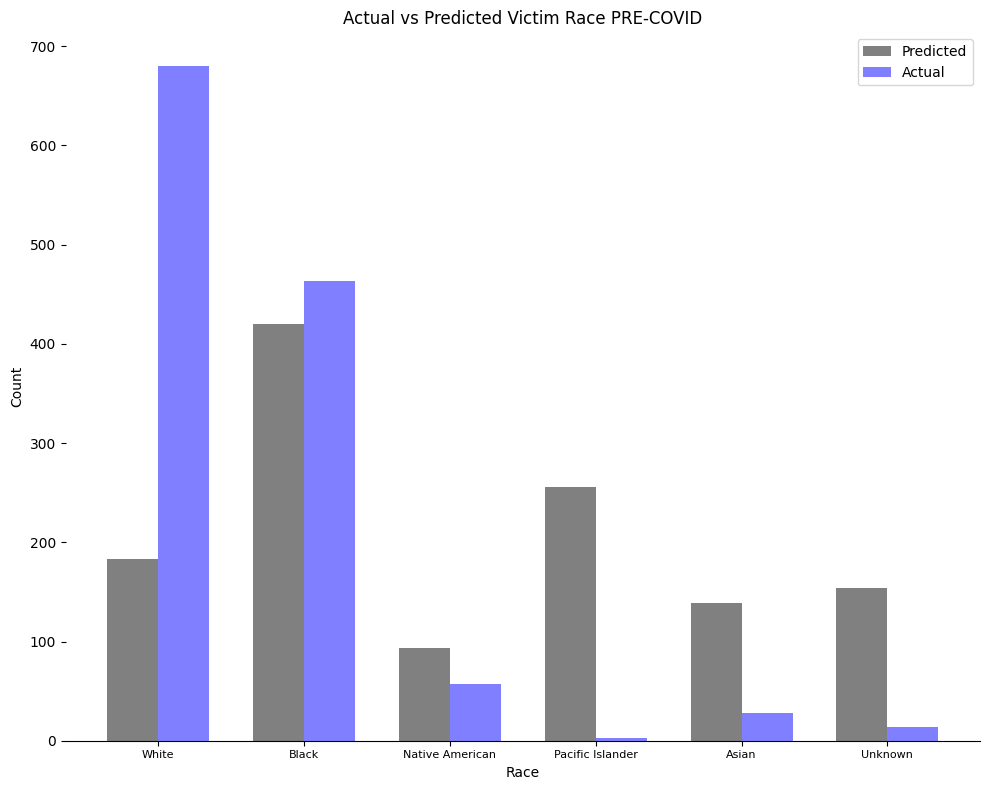

In [ ]:
race_counts = df_test_pre['Predicted'].value_counts()
race_counts_actual = df_test_pre['VicRace'].value_counts()

race_name_map = {
    'Black': 'Black',
    'White': 'White',
    'American Indian or Alaskan Native': 'Native American',
    'Native Hawaiian or Pacific Islander': 'Pacific Islander',
    'Asian': 'Asian',
    'Unknown': 'Unknown'
}

race_counts.index = race_counts.index.map(lambda x: race_name_map.get(x, x))
race_counts_actual.index = race_counts_actual.index.map(lambda x: race_name_map.get(x, x))

desired_race_order = ['White', 'Black', 'Native American', 'Pacific Islander', 'Asian', 'Unknown']
race_counts = race_counts.reindex(desired_race_order, fill_value=0)
race_counts_actual = race_counts_actual.reindex(desired_race_order, fill_value=0)

x = np.arange(len(desired_race_order))
bar_width = 0.35

plt.figure(figsize=(10,8))
plt.bar(x - bar_width/2, race_counts.values, width=bar_width, label='Predicted', color='gray')
plt.bar(x + bar_width/2, race_counts_actual.values, width=bar_width, label='Actual', color='blue', alpha=0.5)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(x, desired_race_order, rotation=0, fontsize=8)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Actual vs Predicted Victim Race PRE-COVID')
plt.legend()
plt.tight_layout()
plt.show()


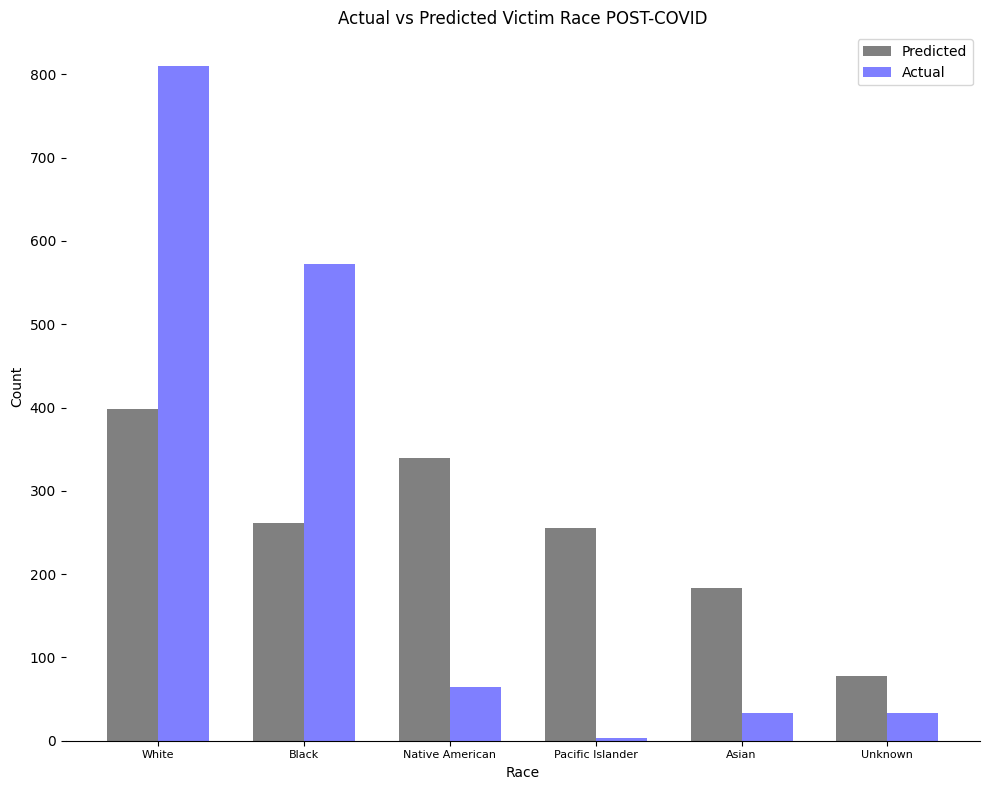

In [ ]:
race_counts = df_test_post['Predicted'].value_counts()
race_counts_actual = df_test_post['VicRace'].value_counts()

race_name_map = {
    'Black': 'Black',
    'White': 'White',
    'American Indian or Alaskan Native': 'Native American',
    'Native Hawaiian or Pacific Islander': 'Pacific Islander',
    'Asian': 'Asian',
    'Unknown': 'Unknown'
}

race_counts.index = race_counts.index.map(lambda x: race_name_map.get(x, x))
race_counts_actual.index = race_counts_actual.index.map(lambda x: race_name_map.get(x, x))

desired_race_order = ['White', 'Black', 'Native American', 'Pacific Islander', 'Asian', 'Unknown']

race_counts = race_counts.reindex(desired_race_order, fill_value=0)
race_counts_actual = race_counts_actual.reindex(desired_race_order, fill_value=0)

x = np.arange(len(desired_race_order))
bar_width = 0.35

plt.figure(figsize=(10,8))

plt.bar(x - bar_width/2, race_counts.values, width=bar_width, label='Predicted', color='gray')
plt.bar(x + bar_width/2, race_counts_actual.values, width=bar_width, label='Actual', color='blue', alpha=0.5)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xticks(x, desired_race_order, rotation=0, fontsize=8)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Actual vs Predicted Victim Race POST-COVID')
plt.legend()
plt.tight_layout()
plt.show()

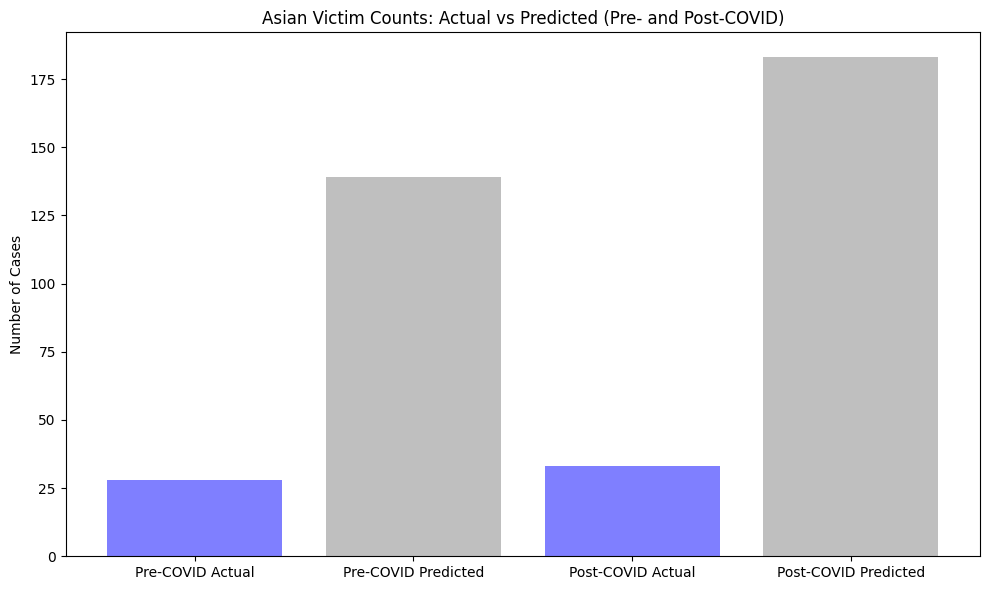

In [483]:
asian_pre_actual = (df_test_pre['VicRace'] == 'Asian').sum()
asian_pre_predicted = (df_test_pre['Predicted'] == 'Asian').sum()

asian_post_actual = (df_test_post['VicRace'] == 'Asian').sum()
asian_post_predicted = (df_test_post['Predicted'] == 'Asian').sum()

labels = ['Pre-COVID Actual', 'Pre-COVID Predicted', 'Post-COVID Actual', 'Post-COVID Predicted']
counts = [asian_pre_actual, asian_pre_predicted, asian_post_actual, asian_post_predicted]

x = np.arange(len(labels))

plt.figure(figsize=(10,6))
plt.bar(x, counts, color=['blue', 'gray', 'blue', 'gray'], alpha=0.5)

plt.xticks(x, labels, rotation=0, fontsize=10)
plt.ylabel('Number of Cases')
plt.title('Asian Victim Counts: Actual vs Predicted (Pre- and Post-COVID)')
plt.tight_layout()
plt.show()


## **Conclusion:**

The findings of this exploration will be for 2 groups of people: those who collect data on crimes, and law enforcement officers who practice aid in the field. 

**For those who collect data on crimes (or in general)**: Based on these findings, the analysts recommend keeping in mind that the representation in data is highly important. If the data was consistently collected throughout the years and the issue with having low amounts of data on against-Asian crimes is that there was less against-Asian crimes, then there's not much one can do about this (in fact one should hope for less against-Asian crimes). If the issue is that against-Asian crimes aren't being represented every time, and that the Unknown VicRace in the data has a large proportion of Asians, then the analysts suggest maintaining vigilance on reporting VicRace every time. This factor will be key in analyzing future data and in maintaining that all populations are represented in analyses that affect the community.

**For law enforcement officers**: This exploration displays that some populations are facing higher murder/manslaughter rates after significant events. As seen in the BBC article on rising hate crimes against Asians, many (east) Asians were blamed for the impact of 'Covid' as people assumed the virus originated from an Asian country (“Covid ‘hate Crimes’ against Asian Americans on Rise.”). In future years, other diseases might be blamed for originating in other continents other than North America, and this can cause great concern for those who identify with the certain regions. The analysts urge law enforcement officers to be vigilant about these types of crimes against certain groups when it comes to large events worldwide. 

Finally, the analysts would like to conclude the analysis with some issues:
1. Talked above, there is a large discrepancy in which populations are represented in the data.
2. The model might overfit occasionally as decision trees train based on the splits of the specific data. If trained on other datasets, the model might yield slightly differing results.

The analysts hope parties involve gain a deeper and statistical-based understanding on the effects of Covid on Asian populations in the United States. In the future, it might be worth exploring Asian-American focused datasets in conjunction with this dataset to see if there's specifics that the analysts have missed on the situation. One might also try different models such as using different regressions rather than a decision classification tree. Even with a classification tree, one might try with different weights on different races and different min leaf nodes sizes. More needs to be explored on this topic, and soon as lives will be impacted on the discussion.

## **Sources:**
“Covid ‘hate Crimes’ against Asian Americans on Rise.” BBC News, BBC, 21 May 2021, www.bbc.com/news/world-us-canada-56218684. 